# Time Series Prediction of Opioid Overdoses

In [230]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [157]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


### Police Overdose Data
https://data.pa.gov/Opioid-Related/Overdose-Information-Network-Data-CY-January-2018-/hbkk-dwy3

This dataset contains summary information on overdose responses and naloxone administrations by Pennsylvania criminal justice agencies and some third-party (i.e. EMS, Fire, Medical Staff, etc) first responders voluntarily entering incident data. Due to the voluntary nature of the application, the ODIN information provided may not represent the totality of all overdose and/or naloxone administration incidents involving criminal justice agencies occurring within the Commonwealth. Although this dataset does include some third-party administrations of naloxone, it should not be used to measure overdose response and naloxone administration incidents among all first responders.

In [132]:
#Read Police Dataset
police_data = pd.read_csv('Overdose_Information_Network_Data_CY_January_2018_-_Current_Monthly_County_State_Police.csv')
print(police_data.columns)
#display(police_data)

Index(['Incident ID', 'Incident Date', 'Incident Time', 'Day',
       'Incident County Name', 'Incident State', 'Victim ID', 'Gender Desc',
       'Age Range', 'Race', 'Ethnicity Desc', 'Victim State', 'Victim County',
       'Accidental Exposure', 'Victim OD Drug ID', 'Susp OD Drug Desc',
       'Naloxone Administered', 'Administration ID', 'Dose Count', 'Dose Unit',
       'Dose Desc', 'Response Time Desc', 'Survive', 'Response Desc',
       'Revive Action Desc', 'Third Party Admin Desc',
       'Incident County FIPS Code', 'Incident County Latitude',
       'Incident County Longitude', 'Victim County FIPS Code',
       'Victim County Latitude', 'Victim County Longitude',
       'Incident County Latitude and Longitude',
       'Victim County Latitude and Longitude'],
      dtype='object')


Police data contains incident IDs for all events, identifying some duplicates.

In [133]:
#Sort police data by date
police_data['Incident Date'] = pd.to_datetime(police_data['Incident Date'])
police_data = police_data.sort_values(by='Incident Date')

In [134]:
#Remove duplicates
police_data = police_data.drop_duplicates(subset="Incident ID")
#display(police_data)

In [135]:
#Create daily counts
police_date_dict = {}

for date in police_data["Incident Date"]:
    if str(date) in police_date_dict: police_date_dict[str(date)] += 1
    else: police_date_dict[str(date)] = 1

police_date_list = sorted(police_date_dict.items())
x,y = zip(*police_date_list)

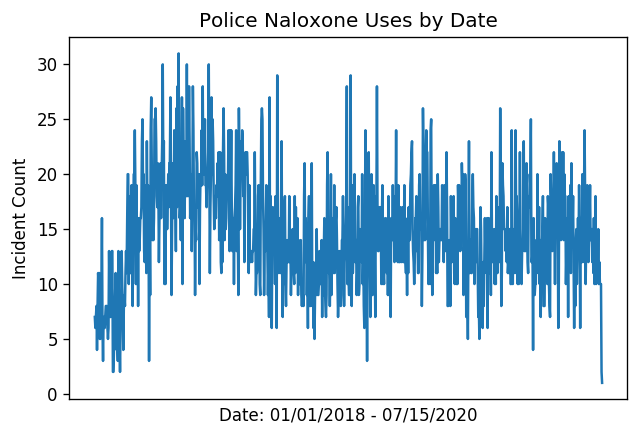

In [136]:
fig = plt.figure(dpi=120)

plt.title("Police Naloxone Uses by Date")
plt.xlabel("Date: 01/01/2018 - 07/15/2020")
plt.ylabel("Incident Count")
plt.xticks([])

plt.plot(list(x),list(y))
plt.show()

Note some irregularities in most/least recent data due to reporting issues.

In [137]:
#Separate date into year, month, date, day for feature normalization
police_daily_data = []
'''
police_daily_data[n] = [year, month, date, day, count]
'''

#01/01/2018 was a Monday
#Using 1-hot feature encoding, we map Monday:1, Tuesday:2, ... Sunday:7
day = 1

#Prune most recent two days (outliers)
for item in police_date_list[:-2]:
    if day == 8: day = 1
    full_date = item[0]
    count = item[1]
    police_daily_data.append([int(full_date[:4]), int(full_date[5:7]), int(full_date[8:10]), day, count])
    day = day+1 #Advance day

### EMS Overdose Data
https://data.pa.gov/Opioid-Related/Emergency-Medical-Services-EMS-Naloxone-Dose-Admin/wst4-3int

This dataset contains information on the number of doses given for Naloxone throughout the Commonwealth of Pennsylvania by County. If the Incident County FIPS Code column is blank it means Not Recorded, as this field was blank by the Patient Care Report (PCR) vendor or the EMS Provider. Data is updated Quarterly starting with the first Quarter of Calendar Year 2018.

In [139]:
#Read EMS Naloxone Dataset from csv
ems_data = pd.read_csv('Emergency_Medical_Services__EMS__Naloxone_Dose_Administered_CY_2018_-_Current_Quarterly_County_Health.csv')
display(ems_data)

,Calendar Year,Event Date,Event Time,Medication Given,Complaint by Dispatch,Record Count,Incident County Number,Incident County,Incident County FIPS Code,Incident County Name,State FIPS,Latitude,Longitude,Georeferenced Latitude & Longitude
0,2018,03/18/2018,5:40:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,9,9,17,Bucks,42,-75.112912,40.335011,POINT (-75.11291241 40.33501133)
1,2018,09/14/2018,11:01:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,51,51,101,Philadelphia,42,-75.140236,40.004444,POINT (-75.140236 40.00444354)
2,2018,12/25/2018,2:36:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,2,2,3,Allegheny,42,-79.986198,40.467355,POINT (-79.98619843 40.46735543)
3,2019,06/21/2019,7:01:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,2,2,3,Allegheny,42,-79.986198,40.467355,POINT (-79.98619843 40.46735543)
4,2018,01/27/2018,6:31:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,2,2,3,Allegheny,42,-79.986198,40.467355,POINT (-79.98619843 40.46735543)
5,2020,05/19/2020,6:04:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,51,51,101,Philadelphia,42,-75.140236,40.004444,POINT (-75.140236 40.00444354)
6,2020,05/22/2020,2:39:00 AM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,38,38,75,Lebanon,42,-76.461826,40.367597,POINT (-76.46182575 40.367597)
7,2018,05/26/2018,12:41:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,40,40,79,Luzerne,42,-75.991996,41.178364,POINT (-75.9919961 41.17836439)
8,2018,02/04/2018,10:34:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,51,51,101,Philadelphia,42,-75.140236,40.004444,POINT (-75.140236 40.00444354)
9,2020,01/09/2020,3:46:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,39,39,77,Lehigh,42,-75.600995,40.614648,POINT (-75.60099481 40.61464794)


In [273]:
#Sort EMS data by date
ems_data['Event Date'] = pd.to_datetime(ems_data['Event Date'])
ems_data = ems_data.sort_values(by='Event Date')
display(ems_data)

,Calendar Year,Event Date,Event Time,Medication Given,Complaint by Dispatch,Record Count,Incident County Number,Incident County,Incident County FIPS Code,Incident County Name,State FIPS,Latitude,Longitude,Georeferenced Latitude & Longitude
5885,2018,2018-01-01,11:08:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,2,2,3,Allegheny,42,-79.986198,40.467355,POINT (-79.98619843 40.46735543)
11917,2018,2018-01-01,2:41:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,4,4,7,Beaver,42,-80.351074,40.683492,POINT (-80.35107356 40.68349245)
3710,2018,2018-01-01,8:00:00 AM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,51,51,101,Philadelphia,42,-75.140236,40.004444,POINT (-75.140236 40.00444354)
11224,2018,2018-01-01,5:25:00 AM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,15,15,29,Chester,42,-75.756265,39.974871,POINT (-75.75626498 39.97487056)
5450,2018,2018-01-01,7:10:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,39,39,77,Lehigh,42,-75.600995,40.614648,POINT (-75.60099481 40.61464794)
8887,2018,2018-01-01,7:35:00 PM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,51,51,101,Philadelphia,42,-75.140236,40.004444,POINT (-75.140236 40.00444354)
10826,2018,2018-01-01,6:38:00 AM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,51,51,101,Philadelphia,42,-75.140236,40.004444,POINT (-75.140236 40.00444354)
1511,2018,2018-01-01,6:17:00 AM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,51,51,101,Philadelphia,42,-75.140236,40.004444,POINT (-75.140236 40.00444354)
10598,2018,2018-01-02,2:28:00 AM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,41,41,81,Lycoming,42,-77.069425,41.344598,POINT (-77.06942457 41.34459792)
2364,2018,2018-01-02,9:10:00 AM,"Naloxone (e.g., Narcan)",Overdose/Poisoning/Ingestion,1,51,51,101,Philadelphia,42,-75.140236,40.004444,POINT (-75.140236 40.00444354)


In [141]:
#Remove duplicates
ems_data = ems_data.drop_duplicates()

In [142]:
#Create daily counts
ems_date_dict = {}

for date in ems_data["Event Date"]:
    if str(date) in ems_date_dict: ems_date_dict[str(date)] += 1
    else: ems_date_dict[str(date)] = 1

ems_date_list = sorted(ems_date_dict.items())
x,y = zip(*ems_date_list)

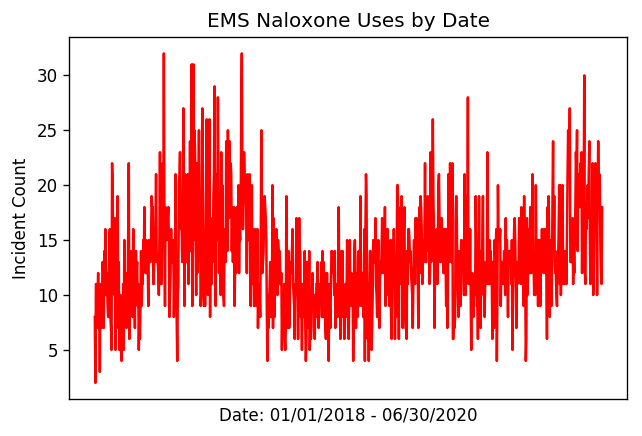

In [143]:
fig = plt.figure(dpi=120)

plt.title("EMS Naloxone Uses by Date")
plt.xlabel("Date: 01/01/2018 - 06/30/2020")
plt.ylabel("Incident Count")
plt.xticks([])

plt.plot(list(x),list(y),color="red")
plt.show()

In [274]:
#Separate date into year, month, date, day for feature normalization
ems_daily_data = []
'''
ems_daily_data[n] = [year, month, date, day, count]
'''

#01/01/2018 was a Monday
#Using 1-hot feature encoding, we map Monday:1, Tuesday:2, ... Sunday:7
day = 1

#Prune most recent two days (outliers)
for item in ems_date_list[:-2]:
    if day == 8: day = 1
    full_date = item[0]
    count = item[1]
    ems_daily_data.append([int(full_date[:4]), int(full_date[5:7]), int(full_date[8:10]), day, count])
    day = day+1 #Advance day

#### Methods of Data Representation for Time Series:

- Tokens where each overdose is a token and the model predicts the next n tokens
- Daily overdoses where each time step is a day and the model predicts # of daily overdoses
- Monthly overdoses (as above) predicting month and breakdown by county

## Tensorflow Police Data LSTM

### Data Representation: Daily Overdoses

In [351]:
tf.random.set_seed(12)

In [260]:
TRAIN_SPLIT = 0.8
BATCH_SIZE = 64
BUFFER_SIZE = 10000

In [261]:
#Univariate data: daily OD counts
#Remove most recent outliers

police_daily_data = pd.DataFrame(police_daily_data,columns=["Year","Month","Date","Day","Count"])

n = len(police_daily_data)

pd_train_data = police_daily_data[:int(n*TRAIN_SPLIT)]
#pd_val_data = police_daily_data[int(n*TRAIN_SPLIT):int(n*0.9)]
pd_test_data = police_daily_data[int(n*TRAIN_SPLIT):]

pd_train_stats = pd_train_data.describe()
pd_train_stats = pd_train_stats.transpose()
pd_train_stats

,count,mean,std,min,25%,50%,75%,max
Year,740.0,2018.520270,0.526299,2018.0,2018.0,2019.0,2019.0,2020.0
Month,740.0,6.451351,3.485762,1.0,3.0,6.0,9.0,12.0
Date,740.0,15.582432,8.828234,1.0,8.0,15.5,23.0,31.0
Day,740.0,3.993243,1.999650,1.0,2.0,4.0,6.0,7.0
Count,740.0,14.702703,5.296691,2.0,11.0,14.0,18.0,31.0


### Feature Normalization

In [262]:
#Feature Normalization
def norm(x,stats):
    return (x - stats['mean']) / stats['std']

normed_pd_train_data = norm(pd_train_data, pd_train_stats)
#normed_pd_val_data = norm(pd_val_data, pd_train_stats)
normed_pd_test_data = norm(pd_test_data, pd_train_stats)

### Time Window Function

In [308]:
#Define time window framework
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [309]:
#Example window with 31 days of input and a prediction label for the 32nd day
w1 = WindowGenerator(31,1,1,normed_pd_train_data, normed_pd_val_data, normed_pd_test_data, label_columns=["Count"])
w1

Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31]
Label column name(s): ['Count']

In [310]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### Plotting Function

In [311]:
def plot(self, model=None, plot_col='Count', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

All shapes are: (batch, time, features)
Window shape: (3, 32, 5)
Inputs shape: (3, 31, 5)
labels shape: (3, 1, 1)


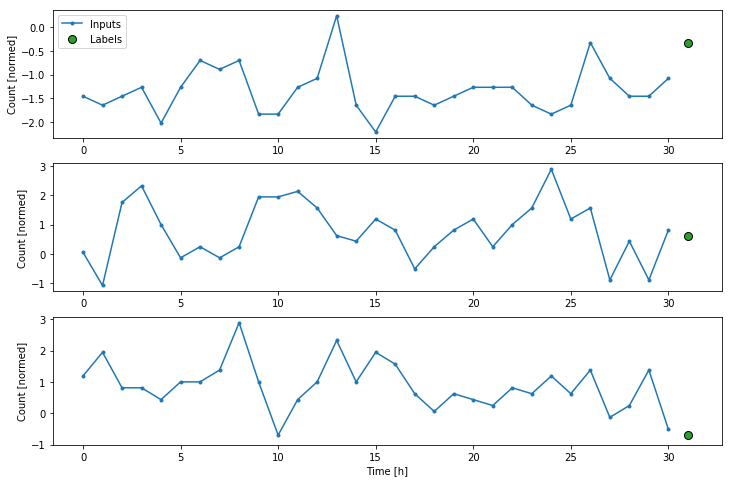

In [312]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(normed_pd_train_data[:w1.total_window_size]),
                           np.array(normed_pd_train_data[100:100+w1.total_window_size]),
                           np.array(normed_pd_train_data[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

w1.example = example_inputs, example_labels

#Visualize three times windows (0:,100:,200:) from the police data
w1.plot()
#plt.savefig("TimeSeries.png",dpi=150)

### Create tf Datasets

In [145]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [146]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Create Sequences

In [358]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE][4] #Count is 5th element
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
SEQUENCE_SIZE = 14
x_train,y_train = to_sequences(SEQUENCE_SIZE,normed_pd_train_data.values.tolist())
#x_val,y_val = to_sequences(SEQUENCE_SIZE,normed_pd_val_data.values.tolist())
x_test,y_test = to_sequences(SEQUENCE_SIZE,normed_pd_test_data.values.tolist())

x_train = np.squeeze(x_train, axis=2)
#x_val = np.squeeze(x_val, axis=2)
x_test = np.squeeze(x_test, axis=2)


print("Shape of training set: {}".format(x_train.shape))
#print("Shape of validation set: {}".format(x_val.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (726, 14, 5)
Shape of test set: (171, 14, 5)


In [359]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64,input_shape=(SEQUENCE_SIZE, 5),return_sequences=False),
        #tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer="adam",loss="mae",metrics=["mse"])

       
    return model

In [360]:
pd_model = build_model()

monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)

pd_model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=100)

Train on 726 samples, validate on 171 samples
Epoch 1/100
726/726 - 2s - loss: 0.7035 - mse: 0.7936 - val_loss: 0.7169 - val_mse: 0.8628
Epoch 2/100
726/726 - 0s - loss: 0.6515 - mse: 0.7057 - val_loss: 0.6063 - val_mse: 0.5996
Epoch 3/100
726/726 - 0s - loss: 0.6369 - mse: 0.6719 - val_loss: 0.6159 - val_mse: 0.6276
Epoch 4/100
726/726 - 0s - loss: 0.6268 - mse: 0.6497 - val_loss: 0.6079 - val_mse: 0.6057
Epoch 5/100
726/726 - 0s - loss: 0.6197 - mse: 0.6476 - val_loss: 0.6171 - val_mse: 0.6258
Epoch 6/100
726/726 - 0s - loss: 0.6134 - mse: 0.6283 - val_loss: 0.6150 - val_mse: 0.6038
Epoch 7/100
726/726 - 0s - loss: 0.6121 - mse: 0.6280 - val_loss: 0.6262 - val_mse: 0.6420
Epoch 8/100
726/726 - 0s - loss: 0.6046 - mse: 0.6210 - val_loss: 0.6171 - val_mse: 0.6064
Epoch 9/100
726/726 - 0s - loss: 0.6005 - mse: 0.6021 - val_loss: 0.6246 - val_mse: 0.6238
Epoch 10/100
726/726 - 0s - loss: 0.5946 - mse: 0.6002 - val_loss: 0.6428 - val_mse: 0.6590
Epoch 11/100
726/726 - 0s - loss: 0.5852 - 

### Evaluate Police LSTM

In [361]:
from sklearn import metrics

pred = pd_model.predict(x_test)
#pred
#y_test
print('R^2: ', sklearn.metrics.r2_score(y_test,pred))
print('MSE: ', sklearn.metrics.mean_squared_error(y_test,pred))
print('Explained Variance: ', sklearn.metrics.explained_variance_score(y_test,pred))

R^2:  -0.004620922780788073
MSE:  0.5995756183558403
Explained Variance:  0.009174159688202677


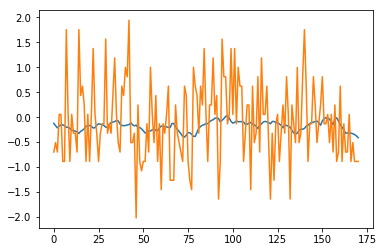

In [391]:
plt.plot(pred)
plt.plot(y_test)
plt.show()

## Tensorflow EMS Data LSTM

In [319]:
TRAIN_SPLIT = 0.8
BATCH_SIZE = 64
BUFFER_SIZE = 10000

In [320]:
ems_daily_data = pd.DataFrame(ems_daily_data,columns=["Year","Month","Date","Day","Count"])

n = len(ems_daily_data)

ems_train_data = ems_daily_data[:int(n*TRAIN_SPLIT)]
#ems_val_data = ems_daily_data[int(n*TRAIN_SPLIT):int(n*0.9)]
ems_test_data = ems_daily_data[int(n*TRAIN_SPLIT):]

ems_train_stats = ems_train_data.describe()
ems_train_stats = ems_train_stats.transpose()
ems_train_stats

,count,mean,std,min,25%,50%,75%,max
Year,728.0,2018.498626,0.500342,2018.0,2018.0,2018.0,2019.00,2019.0
Month,728.0,6.510989,3.442975,1.0,4.0,7.0,9.25,12.0
Date,728.0,15.679945,8.780091,1.0,8.0,16.0,23.00,31.0
Day,728.0,4.000000,2.001375,1.0,2.0,4.0,6.00,7.0
Count,728.0,12.958791,4.789484,2.0,10.0,12.0,16.00,32.0


In [321]:
# Feature Normalization

normed_ems_train_data = norm(ems_train_data, ems_train_stats)
#normed_ems_val_data = norm(ems_val_data, ems_train_stats)
normed_ems_test_data = norm(ems_test_data, ems_train_stats)

In [322]:
# Create Sequences

SEQUENCE_SIZE = 14
ems_x_train,ems_y_train = to_sequences(SEQUENCE_SIZE,normed_ems_train_data.values.tolist())
#x_val,y_val = to_sequences(SEQUENCE_SIZE,normed_pd_val_data.values.tolist())
ems_x_test,ems_y_test = to_sequences(SEQUENCE_SIZE,normed_ems_test_data.values.tolist())

ems_x_train = np.squeeze(ems_x_train, axis=2)
#x_val = np.squeeze(x_val, axis=2)
ems_x_test = np.squeeze(ems_x_test, axis=2)


print("Shape of training set: {}".format(ems_x_train.shape))
#print("Shape of validation set: {}".format(x_val.shape))
print("Shape of test set: {}".format(ems_x_test.shape))

Shape of training set: (714, 14, 5)
Shape of test set: (168, 14, 5)


In [355]:
ems_model = build_model()

monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)

ems_model.fit(ems_x_train, ems_y_train, validation_data=(ems_x_test,ems_y_test), callbacks=[monitor], verbose=2, epochs=100)

Train on 714 samples, validate on 168 samples
Epoch 1/100
714/714 - 2s - loss: 0.7393 - mse: 0.8979 - val_loss: 0.8773 - val_mse: 1.2734
Epoch 2/100
714/714 - 0s - loss: 0.6896 - mse: 0.8021 - val_loss: 0.8048 - val_mse: 1.1022
Epoch 3/100
714/714 - 0s - loss: 0.6760 - mse: 0.7635 - val_loss: 0.8144 - val_mse: 1.0997
Epoch 4/100
714/714 - 0s - loss: 0.6684 - mse: 0.7471 - val_loss: 0.7924 - val_mse: 1.0595
Epoch 5/100
714/714 - 0s - loss: 0.6611 - mse: 0.7408 - val_loss: 0.8376 - val_mse: 1.1449
Epoch 6/100
714/714 - 0s - loss: 0.6580 - mse: 0.7312 - val_loss: 0.8126 - val_mse: 1.1040
Epoch 7/100
714/714 - 0s - loss: 0.6509 - mse: 0.7226 - val_loss: 0.8725 - val_mse: 1.2207
Epoch 8/100
714/714 - 0s - loss: 0.6461 - mse: 0.7106 - val_loss: 0.9059 - val_mse: 1.2877
Epoch 9/100
714/714 - 0s - loss: 0.6383 - mse: 0.7002 - val_loss: 0.7925 - val_mse: 1.0475
Epoch 10/100
714/714 - 0s - loss: 0.6313 - mse: 0.6816 - val_loss: 0.9276 - val_mse: 1.3347
Epoch 11/100
714/714 - 0s - loss: 0.6319 - 

### Evaluate EMS Model

In [356]:
ems_pred = ems_model.predict(ems_x_test)

print('R^2: ', sklearn.metrics.r2_score(ems_y_test,ems_pred))
print('MSE: ', sklearn.metrics.mean_squared_error(ems_y_test,ems_pred))
print('Explained Variance: ', sklearn.metrics.explained_variance_score(ems_y_test,ems_pred))

R^2:  -0.23022373991956213
MSE:  1.0594920420138199
Explained Variance:  0.1666228458012653


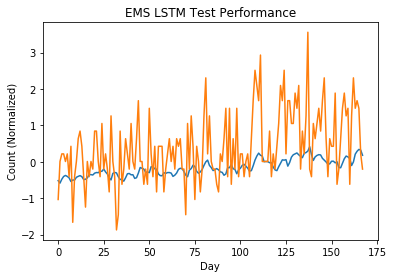

In [392]:
plt.plot(ems_pred)
plt.plot(ems_y_test)
plt.xlabel("Day")
plt.ylabel("Count (Normalized)")
plt.title("EMS LSTM Test Performance")
plt.show()

In [373]:
ems_pred.shape

(168, 1)

### EMS Feedforward Model

In [387]:
ems_ff_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64,activation='relu',input_shape=(14,5)),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(1)
    ])
        
ems_ff_model.compile(loss='mae',optimizer=tf.keras.optimizers.RMSprop(0.001),metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ems_ff_model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 14, 64)            384       
_________________________________________________________________
dense_87 (Dense)             (None, 14, 64)            4160      
_________________________________________________________________
dense_88 (Dense)             (None, 14, 1)             65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [388]:
ems_ff_model.fit(ems_x_train, ems_y_train, validation_data=(ems_x_test,ems_y_test), callbacks=[early_stop], verbose=2, epochs=100)

Train on 714 samples, validate on 168 samples
Epoch 1/100
714/714 - 1s - loss: 0.7453 - mae: 0.7453 - mse: 0.9223 - val_loss: 1.0460 - val_mae: 1.0460 - val_mse: 1.7185
Epoch 2/100
714/714 - 0s - loss: 0.7267 - mae: 0.7267 - mse: 0.8886 - val_loss: 1.1844 - val_mae: 1.1844 - val_mse: 2.0597
Epoch 3/100
714/714 - 0s - loss: 0.7199 - mae: 0.7199 - mse: 0.8727 - val_loss: 0.9600 - val_mae: 0.9600 - val_mse: 1.4908
Epoch 4/100
714/714 - 0s - loss: 0.7142 - mae: 0.7142 - mse: 0.8544 - val_loss: 0.8298 - val_mae: 0.8298 - val_mse: 1.1871
Epoch 5/100
714/714 - 0s - loss: 0.7108 - mae: 0.7108 - mse: 0.8489 - val_loss: 1.0980 - val_mae: 1.0980 - val_mse: 1.8101
Epoch 6/100
714/714 - 0s - loss: 0.7087 - mae: 0.7087 - mse: 0.8391 - val_loss: 0.9332 - val_mae: 0.9332 - val_mse: 1.4193
Epoch 7/100
714/714 - 0s - loss: 0.7066 - mae: 0.7066 - mse: 0.8434 - val_loss: 1.0859 - val_mae: 1.0859 - val_mse: 1.7822
Epoch 8/100
714/714 - 0s - loss: 0.7010 - mae: 0.7010 - mse: 0.8288 - val_loss: 0.7953 - val_

In [389]:
ems_ff_pred = ems_ff_model.predict(ems_x_test)

ems_ff_pred.shape

#print('R^2: ', sklearn.metrics.r2_score(ems_y_test,ems_ff_pred))
#print('MSE: ', sklearn.metrics.mean_squared_error(ems_y_test,ems_ff_pred))
#print('Explained Variance: ', sklearn.metrics.explained_variance_score(ems_y_test,ems_ff_pred))

(168, 14, 1)

In [377]:
ems_x_test.shape

(168, 14, 5)